In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [33]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [34]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [35]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2))

# load files 

In [36]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)

loadfiles = np.load(exp_folder+'\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)

In [37]:
r = RFprop['RF_properties']['radius']

In [38]:
RFprop = RFprop['RF_properties']

In [39]:
STK = SVDnSTK['gauss_RF']

In [40]:
cn = 41

In [41]:
dt=1/60 #large dt will cause  overflow
nstep = int(1./dt)
TKtaxis = np.arange(nstep)*dt
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
TKAS = NGD2L_TK_AS(TKtaxis, *pd.DataFrame(para_dict).loc[cn-1][:-1])

# plot STK

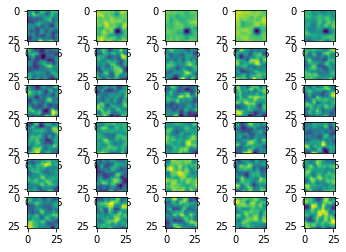

In [42]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(STK[i,:,:,cn-1])

# SVD

In [43]:
rSTK = STK[:,:,:,cn-1].reshape((30,-1))
U,sigma,VT=np.linalg.svd(rSTK)

In [44]:
sigma/np.sum(sigma)

array([0.12541571, 0.0561509 , 0.05130021, 0.04894635, 0.04676808,
       0.04384001, 0.04239741, 0.04114468, 0.03812121, 0.03684327,
       0.0356008 , 0.03370659, 0.03190341, 0.03053385, 0.02962327,
       0.02830902, 0.02751422, 0.02651688, 0.02466724, 0.02360605,
       0.02332516, 0.02264843, 0.02079284, 0.01813239, 0.01770387,
       0.01695337, 0.01594029, 0.01463844, 0.01392739, 0.01302867])

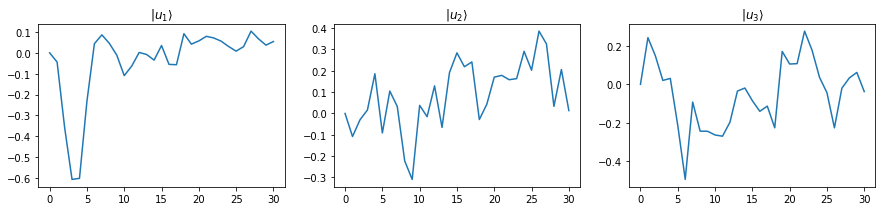

In [45]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax.flatten()[i].plot(np.append(0,U[:,i]))
ax.flatten()[0].set_title(r'$\left| u_1 \right\rangle$')
ax.flatten()[1].set_title(r'$\left| u_2 \right\rangle$')
ax.flatten()[2].set_title(r'$\left| u_3 \right\rangle$')
#     ax.flatten()[i].axes.xaxis.set_visible(False)
plt.gcf().set_size_inches(15, 3)

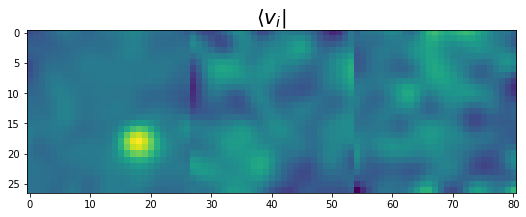

In [46]:
VTtogather=VT[0,:].reshape((27,27))
for i in np.arange(1,3):
    VTtogather = np.hstack((VTtogather, VT[i,:].reshape((27,27))))
plt.imshow(VTtogather)
plt.title(r'$\left\langle {v_i} \right|$', fontsize=20)

plt.gcf().set_size_inches(20, 3)

# STK vs SVD1STK

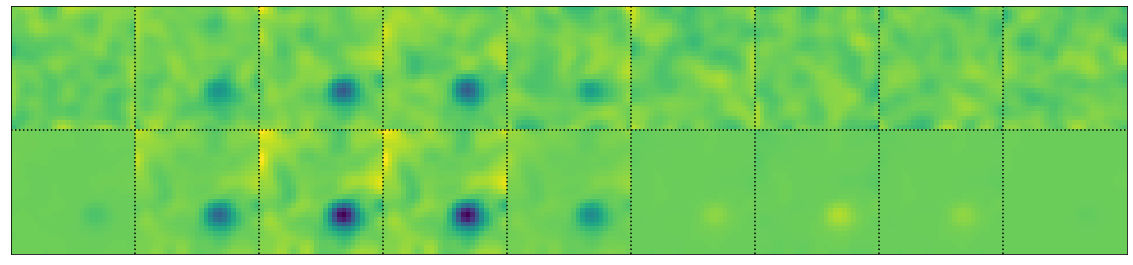

In [47]:
VTtogather =VT[0,:].reshape((27,27))* U[0,0]
STKtogather = STK[0,:,:,cn-1]
for i in np.arange(1,9):
    VTtogather = np.hstack((VTtogather, VT[0,:].reshape((27,27)) * U[i,0] ))
    STKtogather = np.hstack((STKtogather, STK[i,:,:,cn-1] ))
Togather = np.vstack((STKtogather, VTtogather))
fig, ax = plt.subplots(1,1)
ax.imshow(Togather)
ax.axhline(27-0.5, c='k',linestyle=':', zorder = 2)
for i in np.arange(1,9):
    ax.axvline(i*27-0.5, c='k',linestyle=':', zorder = 2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

fig.set_size_inches(20, 5)

# RF
receptive field from 2D Gausian

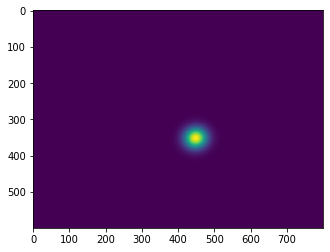

In [48]:
RFellipse = Gaussian_filter_2d_Rot(np.arange(1,801), np.arange(1,601), 
                                 RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'],
                                 RFprop[cn-1]['X_Width']/1.5/BS['micro_per_pixel'],
                                 RFprop[cn-1]['Y_Width']/1.5/BS['micro_per_pixel'],
                                 RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])
plt.imshow(RFellipse)

# MB file

In [49]:
direction = 'UD'

filename = 'merge_0727_OUsmooth_Bright_'+direction+'_G4.5_5min_Q100_6.5mW_1Hz'
MBExp = loadmat(exp_folder+'merge\\'+filename, squeeze_me =True)
BarPos = MBExp['bin_pos']
T=np.arange(len(BarPos))*dt+dt
uBarPos, uI = np.unique(BarPos, return_inverse=True)
if direction == 'UD':
    Inten = 6.5*np.array([np.sum(RFellipse[bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],
                                           400-BS['bar_le']-1:400+BS['bar_wid']])  for bp in uBarPos])
Inten = Inten[uI]

In [50]:
x = Inten
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)

In [51]:
rstate, _ = np.histogram(MBExp['reconstruct_spikes'][cn-1], np.append(0,T))

## convolve with Kernel

In [52]:
STK_onOLED = np.zeros([STK.shape[0], 600, 800])
V1_onOLED = np.zeros([600, 800])
for i in range(267):
    for j in range(267):
        STK_onOLED[:,i+300-1-133, j+400-1-133] = STK[:, int(i/267*27), int(j/267*27), cn-1]
        V1_onOLED[i+300-1-133, j+400-1-133] = VT[0,:].reshape((27,27))[int(i/267*27), int(j/267*27)]

In [53]:
r = np.zeros(len(BarPos))
for i in range(len(BarPos)):
    for ii in np.arange(i-STK.shape[0]+1, i):
        bp = BarPos[ii]
        r[i] += np.sum(STK_onOLED[i-ii ,bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],400-BS['bar_le']-1:400+BS['bar_wid']])

In [54]:
SVDr = 6.5*np.array([np.sum(V1_onOLED[bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],
                                   400-BS['bar_le']-1:400+BS['bar_wid']])  for bp in uBarPos])
SVDr = SVDr[uI]
SVDr = np.convolve(SVDr, U[:,0], 'full')[:len(SVDr)]*sigma[0]

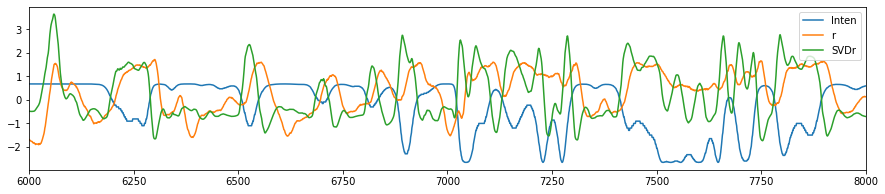

In [55]:
IInten = (Inten-np.mean(Inten))/np.std(Inten)
plt.plot(-IInten, label = 'Inten')

rr = (r-np.mean(r))/np.std(r)
plt.plot(rr, label = 'r')
SVDrr = (SVDr-np.mean(SVDr))/np.std(SVDr)
plt.plot(SVDrr, label = 'SVDr')

plt.legend()
plt.xlim([6000,8000])
plt.gcf().set_size_inches(15,3)

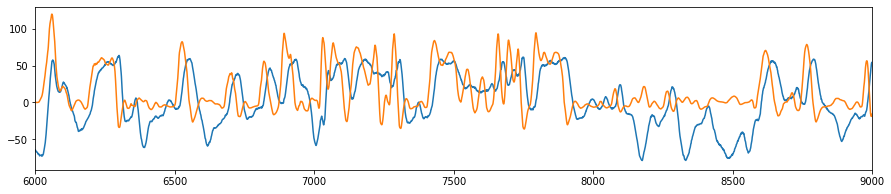

In [56]:
plt.plot(r)
plt.plot(SVDr)
plt.xlim([6000,9000])
plt.gcf().set_size_inches(15,3)

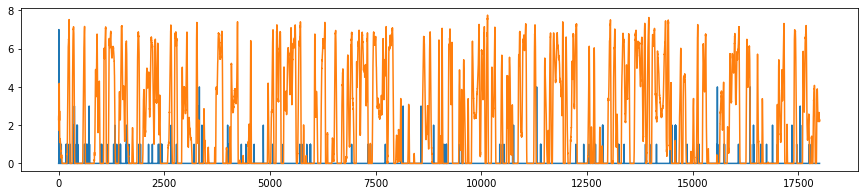

In [57]:
plt.plot(rstate)
plt.plot(NL(r,-10)/10)
# plt.plot(NL(SVDr,0)/100)
# plt.xlim([6000,9000])
plt.gcf().set_size_inches(15,3)

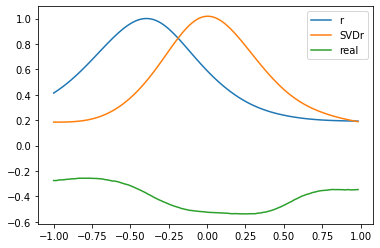

In [58]:
XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, NL(r,0), 'same')/np.correlate(np.ones_like(x), NL(r,0), 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA, label = 'r')

XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, NL(SVDr,0), 'same')/np.correlate(np.ones_like(x), NL(SVDr,0), 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA, label = 'SVDr')

XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA, label = 'real')

plt.legend()

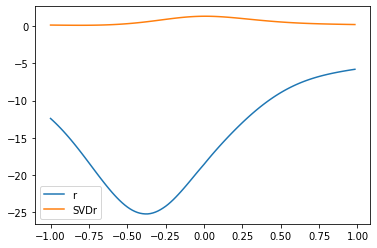

In [59]:
XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, r, 'same')/np.correlate(np.ones_like(x), r, 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA, label = 'r')
plt.legend()

XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, SVDr, 'same')/np.correlate(np.ones_like(x), SVDr, 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA, label = 'SVDr')
plt.legend()

## fake spike

In [60]:
fr = NL(r, 0)
ratio = sum(fr)/T[-1]/12
FakeSpike = Spike_Time_Generater(fr/ratio, dt, 10)
frstate, _ = np.histogram(FakeSpike, np.append(0,T))

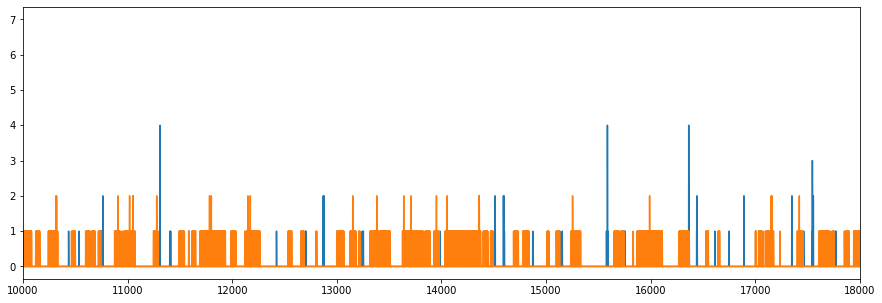

In [61]:
plt.plot(rstate)
plt.plot(frstate)
# plt.plot(NL(SVDr,0)/100)

plt.xlim([10000,18000])
plt.gcf().set_size_inches(15,5)

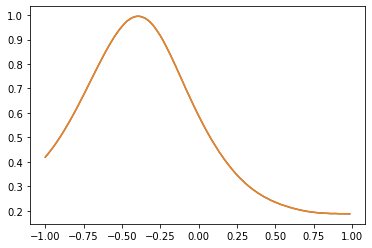

In [62]:
XcT = T-T[int(len(T)/2)]
nXcorr = np.correlate(x, frstate, 'same')/np.correlate(np.ones_like(x), frstate, 'same')
window = [-1, 1]
timeshift = np.arange(window[0],window[1],dt)
STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA)

# XcT = T-T[int(len(T)/2)]
# nXcorr = np.correlate(Inten, SVDr, 'same')/np.correlate(np.ones_like(Inten), SVDr, 'same')
# window = [-1, 1]
# timeshift = np.arange(window[0],window[1],dt)
# STA = nXcorr[np.arange(np.where(XcT == window[0])[0],np.where(XcT ==  window[1])[0])]
plt.plot(timeshift,STA)